Back-Propagation || captura


**Import modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold
import tensorflow.keras as kr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline


**Loading data**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving captura.csv to captura.csv


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "captura.csv" with length 2159 bytes


In [7]:
# Load training data
filename1 = 'captura.csv'
#filename1 = 'bank-additional-full.csv'
bank_additional = pd.read_csv(filename1, delimiter=';', header=0)

# Create a DataFrame
bank_df = pd.DataFrame(bank_additional)
bank_df.head()

,No.,Time,Source,Destination,Protocol,Length
0,1,0.000000,Alcatel-_19:39:41,Spanning-tree-(for-bridges)_00,STP,60
1,2,0.130454,68.55.0.1,224.9.9.4,UDP,783
2,3,0.147551,192.168.168.1,192.168.168.1,ICMP,110
3,4,0.147606,132.32.128.200,132.32.128.200,ICMP,103
4,5,0.374202,172.31.48.1,255.255.255.255,DHCP,367


In [8]:
# Data exploration
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   No.          45 non-null     int64 
 1   Time         45 non-null     object
 2   Source       45 non-null     object
 3   Destination  45 non-null     object
 4   Protocol     45 non-null     object
 5   Length       45 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 2.2+ KB


In [9]:
bank_df.describe()

,No.,Length
count,45.000000,45.000000
mean,23.000000,216.822222
std,13.133926,241.767101
min,1.000000,42.000000
25%,12.000000,82.000000
50%,23.000000,166.000000
75%,34.000000,198.000000
max,45.000000,804.000000


In [ ]:
# Explore the prediction target
bank_df['y'].value_counts()

**Data preprocessing**

In [18]:
# get all categorical columns in the dataframe
catCols = [col for col in bank_df.columns if bank_df[col].dtype=="O"]
print(catCols)

lb_make = LabelEncoder()

for item in catCols:
    bank_df[item] = lb_make.fit_transform(bank_df[item])

bank_df.head()

[]


,No.,Time,Source,Destination,Protocol,Length
0,1,0,22,7,5,60
1,2,1,4,3,6,783
2,3,2,2,1,2,110
3,4,3,0,0,2,103
4,5,5,1,4,1,367


<Axes: >

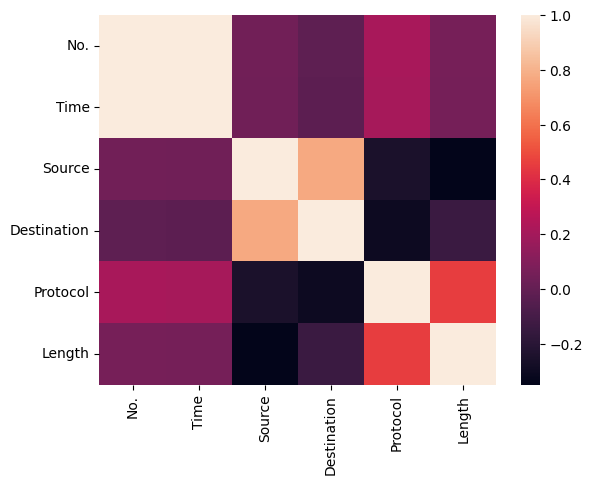

In [19]:
# Check correlation with heatmap graph
corr = bank_df.corr()
sns.heatmap(corr,
xticklabels=corr.columns.values,
yticklabels=corr.columns.values)

In [ ]:
from sklearn.model_selection import train_test_split

X = bank_df.drop(['y'],axis=1).values   # independant features
y = bank_df['y'].values					        # dependant variable

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Normalize the values
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


**Cross validation || using Keras**

In [ ]:
learning_rate = 0.01  # learning rate
momentum = 0.05       # momentum
nn = [20, 100, 25, 5, 1]  # number of neurons for each layer

fold_no = 1

cv_percentage_classification_errors = list()

# 4-fold cross-validation
kf = KFold(n_splits=4, shuffle=True)
for train, validation in kf.split(X_train):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    model = kr.Sequential()

    l1 = model.add(kr.layers.Dense(nn[1], activation='relu'))
    l2 = model.add(kr.layers.Dense(nn[2], activation='relu'))
    l3 = model.add(kr.layers.Dense(nn[3], activation='relu'))
    l4 = model.add(kr.layers.Dense(nn[4], activation='sigmoid'))

    model.compile(loss='mse', optimizer=kr.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), metrics=['acc'])

    history = model.fit(X_train[train], y_train[train], epochs=1000)

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # Generate predictions
    y_pred = model.predict(X_train[validation])
    #print(y_train[validation], y_pred)
    plt.hist(y_pred, bins=2)

    # Use a threshold to select the probabilities that will determine class 0 or 1
    threshold = 0.5
    y_pred = np.where(y_pred > threshold, 1,0)

    # Evaluate by means of a confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_train[validation], y_pred,
                                                    cmap=plt.cm.Blues,
                                                    normalize='true')
    plt.show()

    cm = confusion_matrix(y_train[validation], y_pred)
    print('Confusion matrix:\n', cm)

    # Calculate the percentage classification error obtained from validation test
    percentage_classification_error = 100 * ((cm[0][1] + cm[1][0]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))
    print(f'Percentage classification error obtained from validation set: {percentage_classification_error}%')

    cv_percentage_classification_errors.append(percentage_classification_error)

    # Increase fold number
    fold_no = fold_no + 1

print('\nResults of cross validation:')
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Percentage classification error obtained from validation set per fold')
for i in range(0, len(cv_percentage_classification_errors)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - {cv_percentage_classification_errors[i]}%')
print('------------------------------------------------------------------------')
# Calculate the mean percentage classification error obtained from cross-validation
print('Mean percentage classification error obtained from cross validation:')
print(f'> {np.mean(cv_percentage_classification_errors)}% (+- {np.std(cv_percentage_classification_errors)})')
print('------------------------------------------------------------------------')

**Training using Keras**

In [ ]:
learning_rate = 0.01  # learning rate
momentum = 0.05       # momentum
nn = [20, 100, 25, 5, 1]  # number of neurons for each layer

model = kr.Sequential()

l1 = model.add(kr.layers.Dense(nn[1], activation='relu'))
l2 = model.add(kr.layers.Dense(nn[2], activation='relu'))
l3 = model.add(kr.layers.Dense(nn[3], activation='relu'))
l4 = model.add(kr.layers.Dense(nn[4], activation='sigmoid'))

model.compile(loss='mse', optimizer=kr.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), metrics=['acc'])

history = model.fit(X_train, y_train, epochs=1000)

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


**Test || Keras**

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)

# Use a threshold to select the probabilities that will determine class 0 or 1
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1,0)

# Evaluate by means of a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
																								cmap=plt.cm.Blues,
																								normalize='true')
plt.show()

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

# Calculate the percentage classification error obtained from test set
percentage_classification_error = 100 * ((cm[0][1] + cm[1][0]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))
print(f'Percentage classification error obtained from test set: {percentage_classification_error}%')

In [ ]:
y_pred = np.concatenate(y_pred, axis=0)

bank_bp_results = { 'real_value': y_test,
                    'prediction': y_pred}

df = pd.DataFrame(bank_bp_results)

df.to_csv('bank_bp_results.csv')

In [ ]:
weights = model.get_weights()
np.savetxt('bank_bp_model_weights.csv', weights, fmt='%s', delimiter=',')

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:1533: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("captura_bp_model.json", "w") as json_file:
    json_file.write(model_json)